In [150]:
from dotenv import load_dotenv
import os
import json
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

load_dotenv(dotenv_path="./.env")
KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME", "")
KAGGLE_KEY = os.environ.get("KAGGLE_KEY", "")
RAW_DATA_PATH = os.environ.get("RAW_DATA_PATH", "")

In [33]:
submission_data = pd.read_csv(RAW_DATA_PATH + "//sample_submission.csv")
test_data = pd.read_csv(RAW_DATA_PATH + "//test.csv")
train_data = pd.read_csv(RAW_DATA_PATH + "//train.csv")

# Short overview

In [98]:
relevant_cols = ["feat", "dtype", "count", "N/A", "nunique"]
df_info = pd.DataFrame(columns = relevant_cols)
agg_data = np.array(relevant_cols)

for col in train_data.columns.to_list():
    data = np.array([])
    data = np.append(data, col)
    data = np.append(data, train_data[col].dtype)
    data = np.append(data, train_data[col].shape[0])
    data = np.append(data, train_data[col].isnull().sum())
    data = np.append(data, train_data[col].nunique())
    
    agg_data = np.vstack((agg_data, data))
    
df_info = pd.DataFrame(agg_data).iloc[1:].rename({k:v for k, v in enumerate(relevant_cols)}, axis = 1)

df_info

,feat,dtype,count,N/A,nunique
1,id,int64,1235,0,1235
2,surgery,object,1235,0,2
3,age,object,1235,0,2
4,hospital_number,int64,1235,0,255
5,rectal_temp,float64,1235,0,43
6,pulse,float64,1235,0,50
7,respiratory_rate,float64,1235,0,37
8,temp_of_extremities,object,1235,39,4
9,peripheral_pulse,object,1235,60,4
10,mucous_membrane,object,1235,21,6


In [207]:
numerical_feats = [feat for feat in df_info[df_info["dtype"]!="object"]["feat"] if (feat in df_info[df_info["dtype"]!="object"]["feat"].values and feat not in ["id"])]
categorical_feats = [feat for feat in df_info["feat"] if (feat not in numerical_feats and not feat in ["id"])]

In [279]:
a = train_data[["surgery", "outcome"]]

In [298]:
a

,surgery,outcome
0,yes,died
1,yes,euthanized
2,yes,lived
3,yes,lived
4,no,lived
...,...,...
1230,yes,lived
1231,yes,died
1232,yes,lived
1233,yes,lived


In [296]:
pd.pivot_table(data=a, index="surgery", values=["outcome"], aggfunc="count")

,outcome
surgery,
no,348
yes,887


In [291]:
a.groupby(["surgery", "outcome"])["surgery"].count()

surgery  outcome   
no       died           74
         euthanized     79
         lived         195
yes      died          336
         euthanized    172
         lived         379
Name: surgery, dtype: int64

In [289]:
a

,surgery,outcome
0,yes,died
1,yes,euthanized
2,yes,lived
3,yes,lived
4,no,lived
...,...,...
1230,yes,lived
1231,yes,died
1232,yes,lived
1233,yes,lived


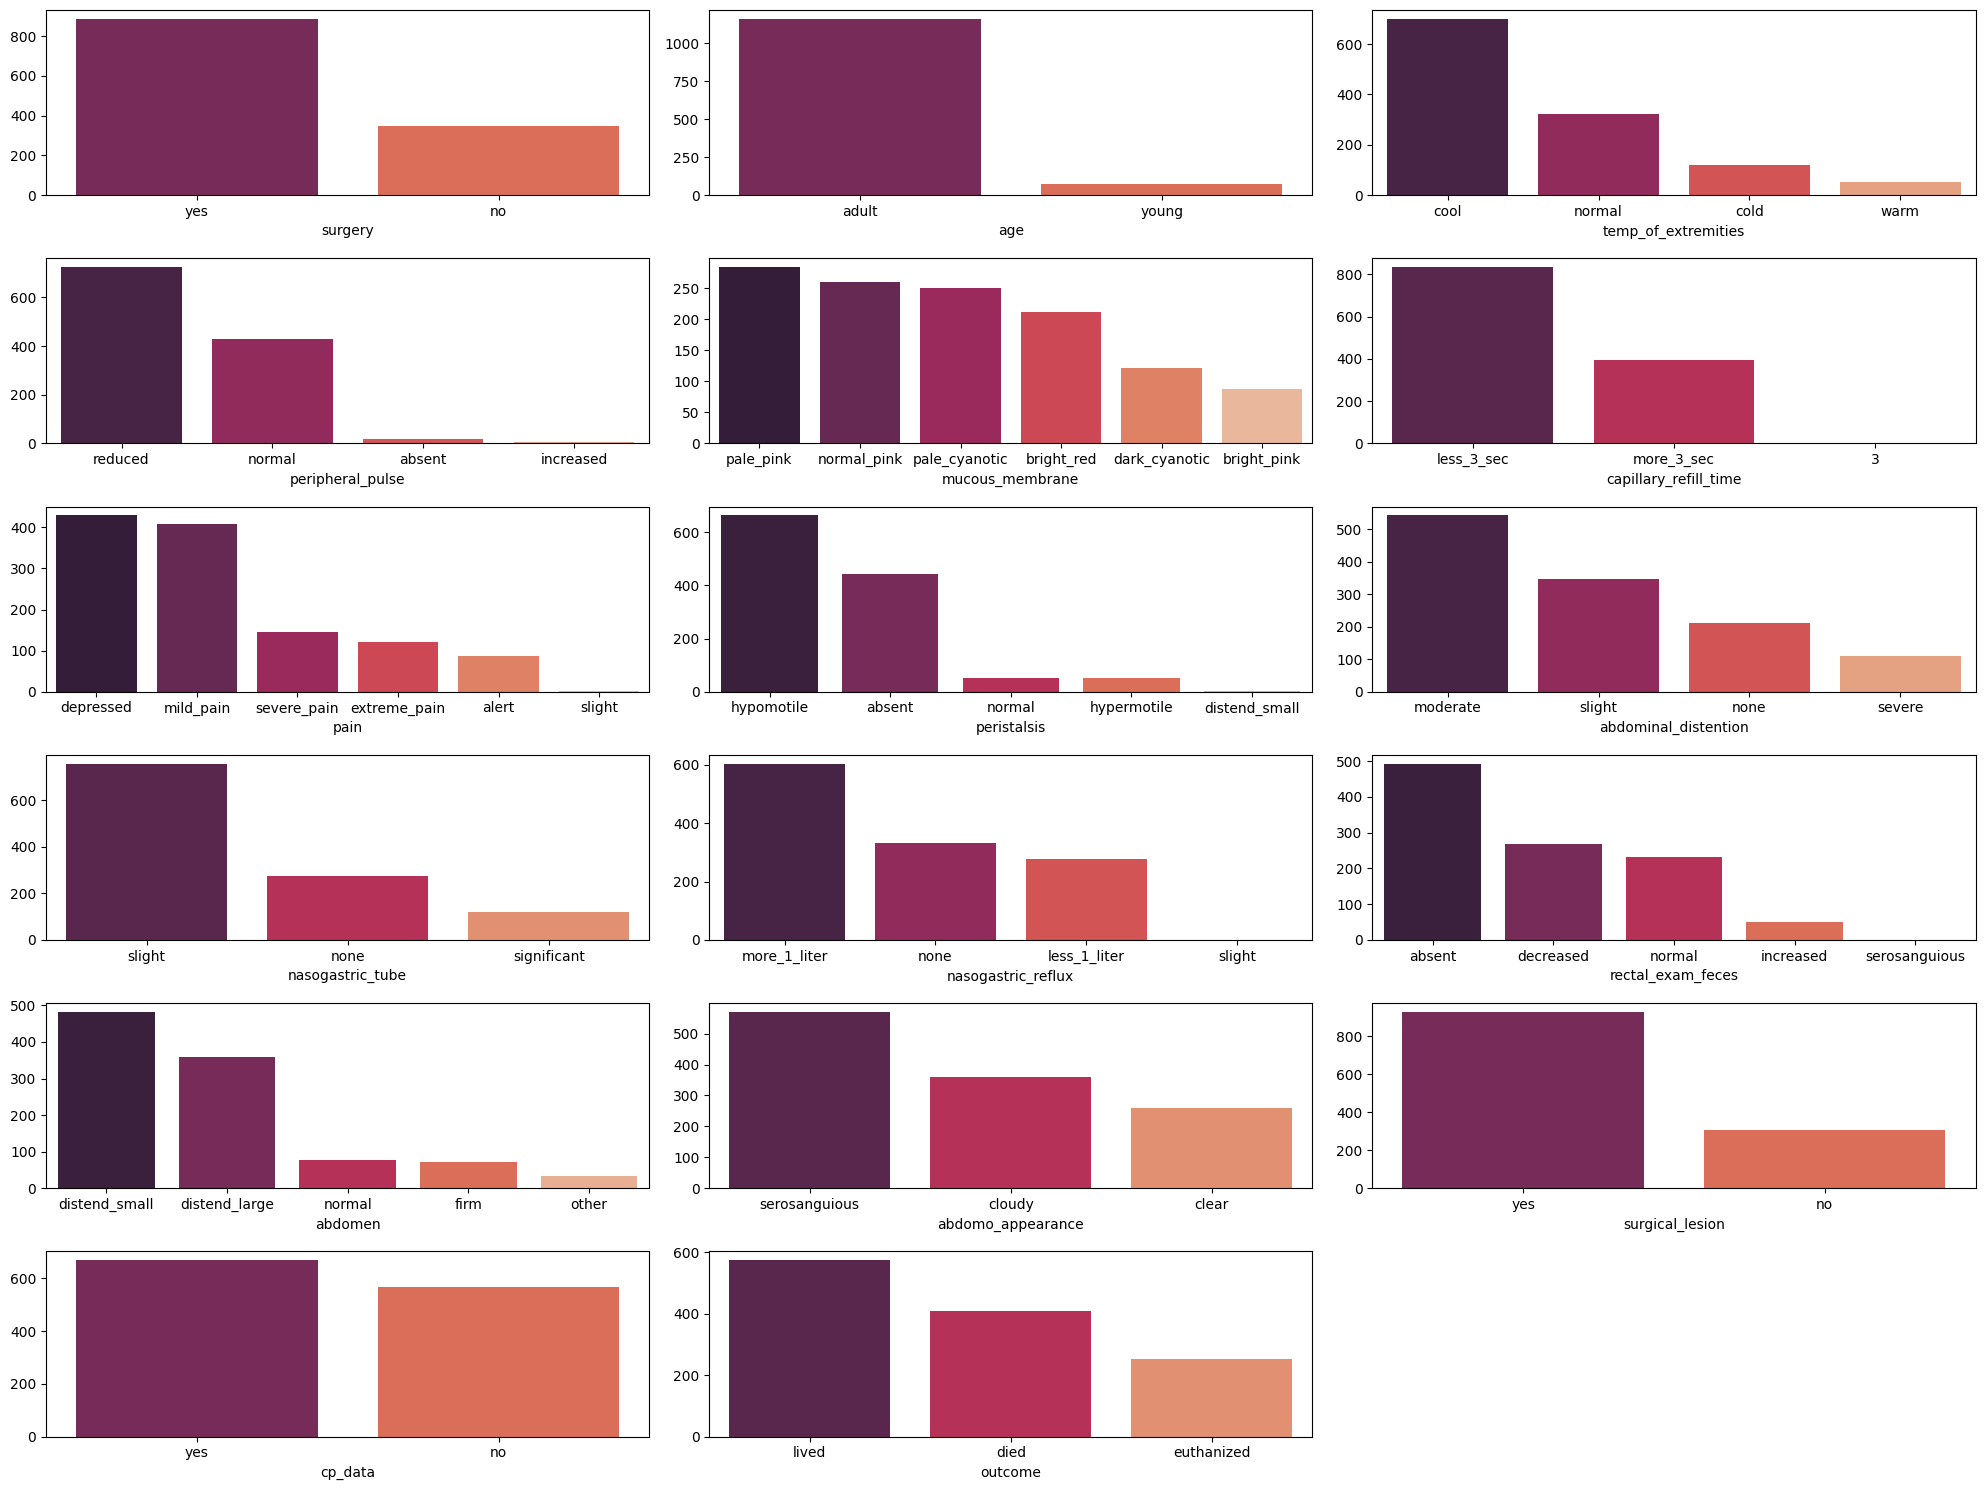

In [273]:
fig, sub = plt.subplots(6,3,figsize=(20,15))
sub_arr = sub.flatten()
feats = df_info[df_info["dtype"] == "object"]["feat"].values

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(categorical_feats):
        tmp_data = train_data[categorical_feats[i]].value_counts()    
        sns.barplot(
            x = tmp_data.index,
            y = tmp_data.values,
            ax = sub_plot,
            palette = "rocket",
        )
            
    else:
        sub_plot.set_visible(False)
        
    
fig.tight_layout()    
    

* **surgery:** has the horse been operated?
* **age:** is the horse young / adult?
* **temp_of_extremities:** which temperature has the horse?
* **peripheral_pulse:** Pulse of the horse?
* **mucous_membrane:** Color of the tooth gums?
* **capillary_refill_time:** How long does it take to refill the gums after pressing on it, with blood (sign 
of dehydration)
* **pain:** categorical description of the pain the horse is exposed to
* **peristalsis:** How are the muscles for the transport of food working? 
* **abdominal_distention:** Abdominal sweeling 
* **abdomen:** Status of the abdomen
* **abdomo_appearance:** Appearance of the abdomen
* **surgical_lesion:** Wound of surgical operation
* **cp_data:** ???
* **Outcome:** Fate of the horse (=>died, euthanized or survived)

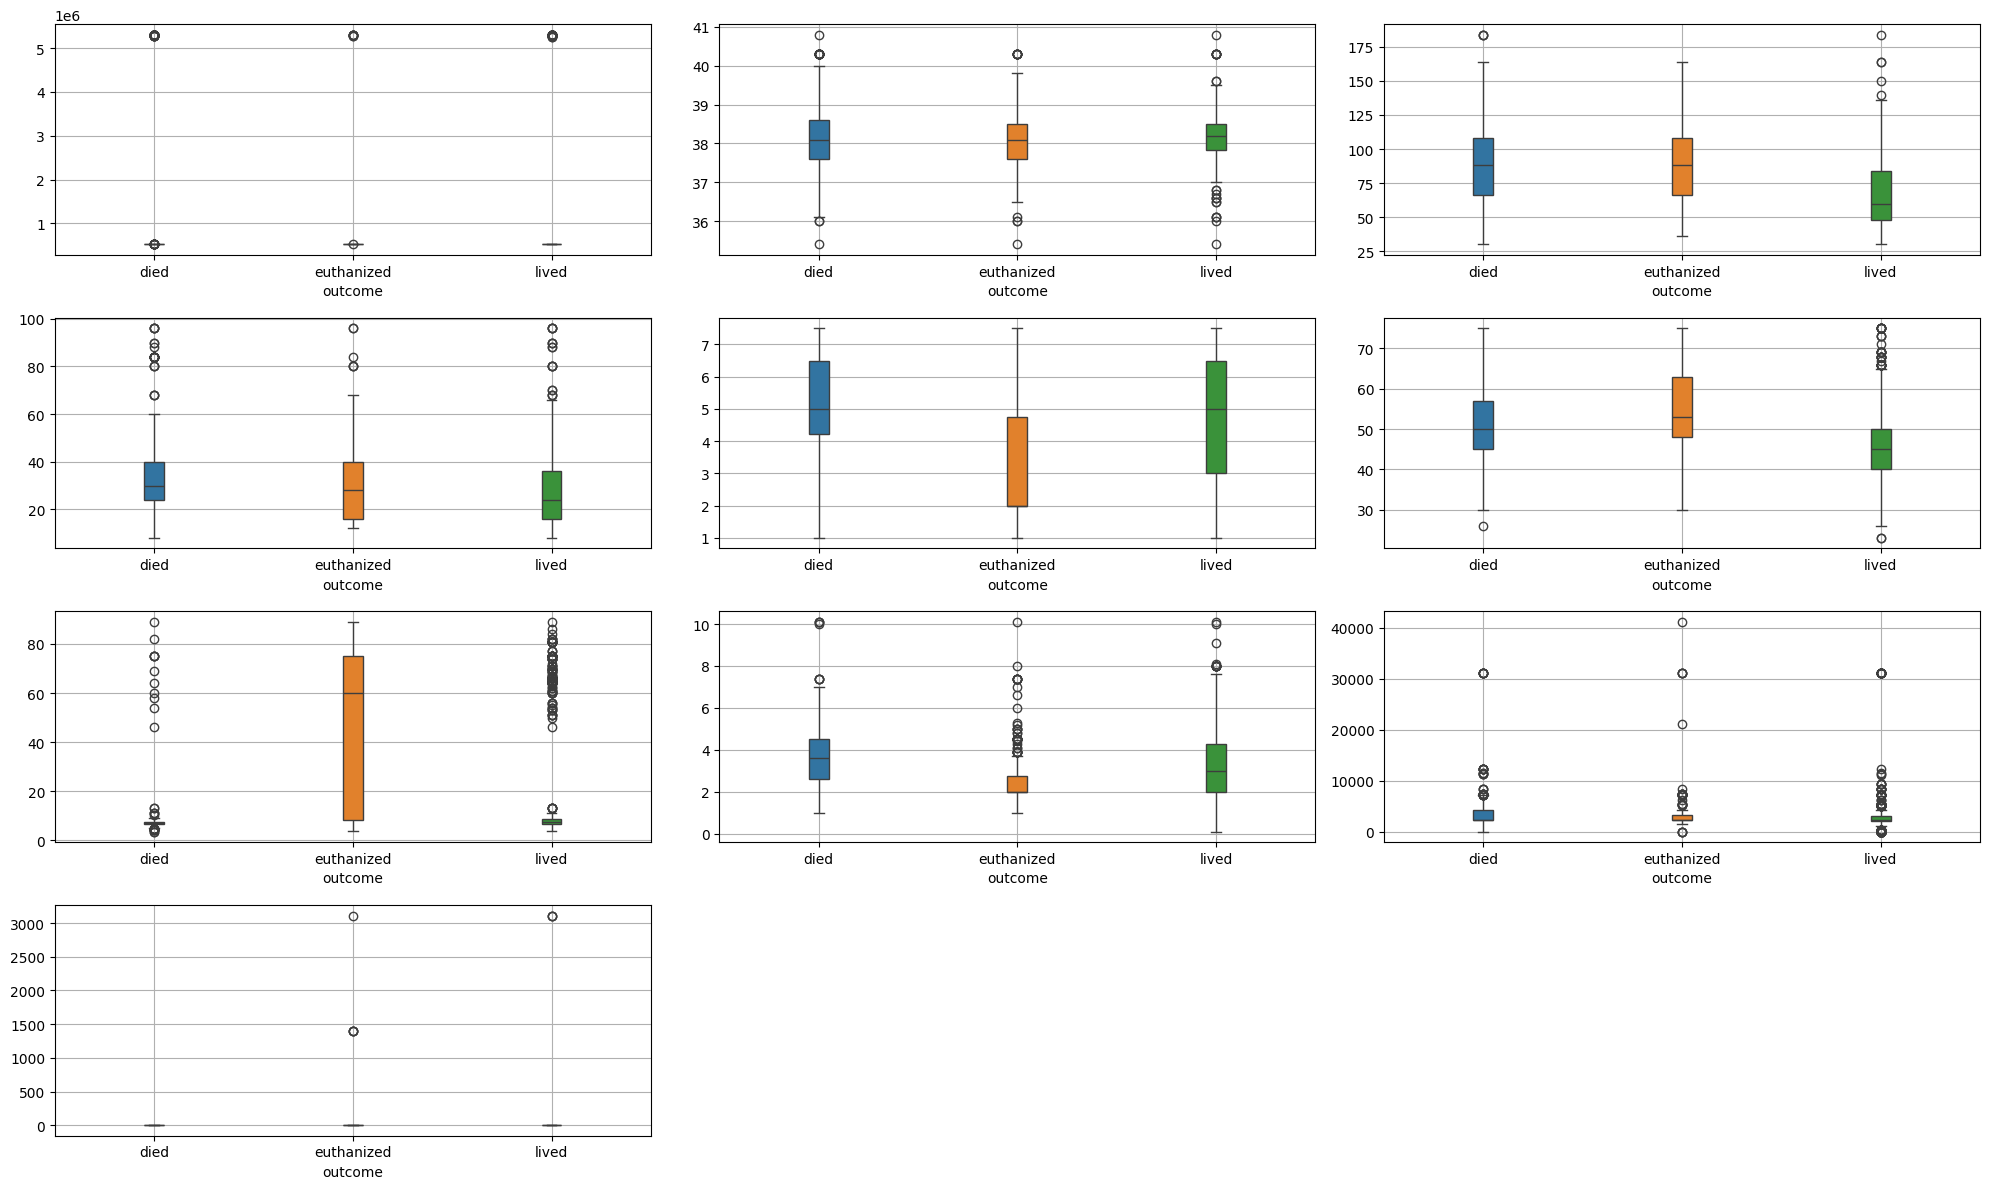

In [272]:
fig, sub = plt.subplots(4,3,figsize=(20,12))
sub_arr = sub.flatten()

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(numerical_feats[:-1]):
        tmp_data = train_data[[numerical_feats[i], "outcome"]]    
        tmp_data_pivot = pd.pivot(data=tmp_data, columns="outcome", values=numerical_feats[i])
        sns.boxplot(
            data=tmp_data_pivot,
            ax = sub_plot,
            width = 0.1,
        )
        sub_plot.grid()
            
    else:
        sub_plot.set_visible(False)
        
    
fig.tight_layout()   

* **rectal_temp:** Temperature measured in the after
* **pulse:** Pulse measured
* **respiratory_rate:** at which rate is the horse's respiration
* **Nasogastric reflux ph:** PH value of the horse's reflux
* **packed_cell_volume:** vol of the horse's cells
* **total_protein:** ???
* **abdomo_protein:** ???
* **lesion 1-3:** ???